In [1]:
try:
  # Install colab required dependencies
  import google.colab
  !pip install -q tf-agents
except:
  pass

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.ddpg import ddpg_agent, critic_network, actor_network, critic_rnn_network, actor_rnn_network
from tf_agents.specs import tensor_spec, array_spec
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents import utils
from tf_agents.trajectories import time_step as ts

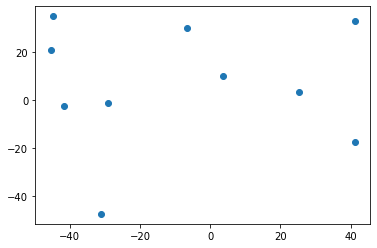

In [3]:
# Number of sensing locations
locations_num = 10

# Size of the map (the map is squared)
map_size = 100.0

# Coordinates of the sensing locations
sensing_locations = (np.random.rand(locations_num, 2) * map_size) - (map_size / 2)

_ = plt.scatter(sensing_locations[:,0], sensing_locations[:,1])

In [4]:
# Number of drones
drones_num = 5

# Length of a single cycle in seconds
cycle_length = 1.0

# Maximum speed of drones in points / seconds
max_speed = 5.0

# Definition of the global state

# Coordinates of the drones locations
drones_locations = np.zeros((drones_num, 2), dtype=float)

# Amounts of sensing data to send per drone
sensing_data_amounts = np.zeros(drones_num, dtype=float)

# AoIs (age of information) per sensing location. Denotes the last cycle in which
# any drone performed sensing at a specific sensing location
aois = np.zeros(locations_num, dtype=int)

# Indices of the chosen locations per drone. They are chosen in the decision cycles.
# The initial values are not significant.
chosen_locations = np.zeros(drones_num, dtype=int)

# Stage of the cycle for every drone
# 0 -> decision, 1 -> empty, 2 -> sensing, 3 -> transmission
cycle_stages = np.zeros(drones_num, dtype=int)


# Returns the AoI of the given location
def get_location_aoi(cycle, location_index):
    return (cycle * cycle_length) - ((aois[location_index] // cycle_length) * cycle_length)

# Returns the accumulated AoI (of all the sensing locations)
def get_accumulated_aoi(cycle):
    return max([sum([get_location_aoi(cycle, location) for location in range(locations_num)]), 0.0001])

# Returns the trajectory for the current cycle 
def get_trajectory(drone_index):
    chosen_location_index = chosen_locations[drone_index]
    chosen_location = sensing_locations[chosen_location_index]
    drone_location = drones_locations[drone_index]
    distance = np.linalg.norm(chosen_location - drone_location)
    if distance <= max_speed * cycle_length:
        return chosen_location - drone_location
    else:
        return ((chosen_location - drone_location) / distance) * max_speed * cycle_length

In [5]:
# Simplifying transmission step: only considering a bandwidth and a total amount of
# data for every location. Assumption: tasks are equal, so the amount of data is the same.

# Transmission bandwidth per cycle
bandwidth = 0.5

# Total amount of sensing data per location
total_location_data = 1.5

# Amount of data transmissible per cycle 
data_transmission_cycle = bandwidth * cycle_length

In [6]:
# Agents definition

'''
Using Deep Q Learning. Having current drone location (x,y), 
potential sensing location (x',y') (could also directly consider distance
between the two locations) and AoI of the sensing location
as features, the network should output a Q value. The higher
the value the better this sensing location choice. Executing the network
at the decision cycle for every sensing location and choosing the one
that outputs the highest Q value. After each decision, the Q network
should be updated by performing backpropagation and considering the error.
'''


class DurpEnv(py_environment.PyEnvironment):
    def __init__(self, drone):
        self._drone = drone
        self.cycle = 1
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.float64, minimum=0, maximum=locations_num-0.001, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(2,),
            minimum=(-map_size/2), maximum=(map_size/2), dtype=np.float64)
        
        self._state = 0 # TODO: not sure if we need this
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._episode_ended = False
        return ts.restart(np.array([0.0,0.0], dtype=np.float64))

    def _step(self, action):
        '''
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        '''

        # Performing next step

        chosen_location_index = int(action)

        accumulated_aoi = get_accumulated_aoi(self.cycle)

        # Updating AoI of chosen destination
        aois[chosen_location_index] = self.cycle

        # Calculating reward considering new accumulated AoI (sum of AoIs) 
        # and distance from chosen location
        new_accumulated_aoi = get_accumulated_aoi(self.cycle)

        aoi_multiplier = 0.05

        # Using sigmoid function to obtain a value between 0 and 1. The 
        # higher the aoi difference the better, so the higher
        # the reward.
        normalized_diff_aoi_component = \
            ((1/(1+np.exp(- (accumulated_aoi - new_accumulated_aoi) * aoi_multiplier))) - 0.5) * 2.0


        # Taking distance between current location and chosen location
        chosen_location = sensing_locations[chosen_location_index]
        drone_location = drones_locations[self._drone]
        distance = np.linalg.norm(chosen_location - drone_location)

        distance_multiplier = 0.03

        # Normalizing distance
        # between 0 and 1. The smaller the distance, the higher the reward.
        normalized_location_distance = (1 - (1/(1+np.exp(-distance * distance_multiplier)))) * 2.0

        # Computing reward using weights
        aoi_weight = 0.99
        reward = normalized_diff_aoi_component * aoi_weight + normalized_location_distance * (1.0 - aoi_weight)

        #print("Action: ", action)
        #print("Reward: ", normalized_diff_aoi_component)

            
        self.cycle += 8

        return ts.transition(chosen_location, reward=reward)

        
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

environments = []
agents = []
for drone in range(drones_num):

    durp_env = DurpEnv(drone)

    train_env = tf_py_environment.TFPyEnvironment(durp_env)

    actor_rnn_net = actor_rnn_network.ActorRnnNetwork(
        train_env.observation_spec(), 
        train_env.action_spec()
    )

    critic_rnn_net = critic_rnn_network.CriticRnnNetwork(
        (train_env.observation_spec(), train_env.action_spec()), 
        lstm_size=[2]
        #output_activation_fn=tf.keras.activations.sigmoid,
        #activation_fn=tf.nn.relu
    )

    actor_net = actor_network.ActorNetwork(
        train_env.observation_spec(), 
        train_env.action_spec()
    )

    critic_net = critic_network.CriticNetwork(
        (train_env.observation_spec(), train_env.action_spec()), 
        output_activation_fn=tf.keras.activations.sigmoid,
        activation_fn=tf.nn.relu
    )

    '''
    q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,))'''

    agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    critic_network=critic_net,
    actor_network=actor_net,
    critic_optimizer=optimizer,
    actor_optimizer=optimizer,
    #td_errors_loss_fn=utils.common.element_wise_squared_loss,
    #train_step_counter=tf.Variable(0)
    )

    agent.initialize()
    agents.append(agent)
    environments.append(train_env)

In [7]:
# Training step

num_iterations = 500 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)


for i in range(len(agents)):
    agent = agents[i]
    env = environments[i]

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.collect_data_spec,
        batch_size=env.batch_size)

    random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())
                                                
    aois = np.zeros(locations_num, dtype=int)

    collect_data(env, random_policy, replay_buffer, initial_collect_steps)


    aois = np.zeros(locations_num, dtype=int)


    dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2,
    single_deterministic_pass=False).prefetch(3)
    iterator = iter(dataset)
        
    # Reset the train step
    agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    #avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    #returns = [avg_return]

    for i in range(num_iterations):
        aois = np.zeros(locations_num, dtype=int)
        
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(env, agent.collect_policy, replay_buffer, 1)
       
        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience).loss

        #print(train_loss)

        step = agent.train_step_counter.numpy()

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [8]:
# Simulation

time_steps = []
for drone in range(drones_num):
    time_steps.append(environments[drone].reset())

# Number of total cycles for the simulation
cycles_num = 1000

aois = np.zeros(locations_num, dtype=int)

# Running simulation (one cycle at a time for every drone)
for cycle in range(1, cycles_num + 1):

    #print(aois)
    if cycle % 100 == 1:
        #print(drones_locations)
        print(get_accumulated_aoi(cycle))
        print(aois)
        print("----------------")
    for drone in range(drones_num):
        #aoi = get_location_aoi(cycle, chosen_locations[drone])
        # if aoi == cycle_length:
        #print(cycle_stages[drone])
        if cycle_stages[drone] == 0:  # Decision cycle
            agent = agents[drone]
            env = environments[drone]
            agent.cycle = cycle
            #print(cycle, agent.cycle)
            #print( drones_locations[drone])
            policy_step = \
                agent.policy.action(time_steps[drone]) 
                # (action: , state: )
            new_step = env.step(policy_step.action)
            #print(time_steps[drone])
            time_steps[drone] = new_step
            #print(time_steps[drone])
            #print(new_step.reward)
            #print(int(policy_step.action))
            #print(sensing_locations[chosen_locations[drone]])
            chosen_locations[drone] = int(policy_step.action)
            cycle_stages[drone] =  1
        elif (drones_locations[drone] != sensing_locations[chosen_locations[drone]]).all(): # Empty cycle
            #print( drones_locations[drone])
            traj = get_trajectory(drone)
            new_location = drones_locations[drone] + traj
            # Updating drone location
            drones_locations[drone] = new_location
        elif sensing_data_amounts[drone] == 0.0: # Sensing cycle
            cycle_stages[drone] =  2
            # Updating drone sensing data remaining amount
            sensing_data_amounts[drone] = total_location_data
            cycle_stages[drone] =  3
        else: # Transmission cycle
            # Updating drone sensing data remaining amount
            sensing_data_amounts[drone] = \
                np.max([sensing_data_amounts[drone] - data_transmission_cycle, 0.0])
            # Updating the AoI if the transmission has been completed
            if sensing_data_amounts[drone] == 0.0:
                aois[chosen_locations[drone]] = cycle
                cycle_stages[drone] =  0

10.0
[0 0 0 0 0 0 0 0 0 0]
----------------
0.0001
[   0    0    0    0    0   97    0 4841   94 4937]
----------------
0.0001
[   0    0    0    0    0  159    0  194  200 5097]
----------------
0.0001
[   0    0    0    0    0  283    0 4921 4929 5257]
----------------
0.0001
[   0    0    0    0    0 4953    0  394 4961 5417]
----------------
0.0001
[   0    0    0    0    0  469    0 5001  494 5577]
----------------
0.0001
[   0    0    0    0    0  593    0  594 5041 5737]
----------------
0.0001
[   0    0    0    0    0 5073    0 5081  698 5897]
----------------
0.0001
[   0    0    0    0    0  779    0  794 5121 6057]
----------------
0.0001
[   0    0    0    0    0 5145    0 5161  894 6217]
----------------


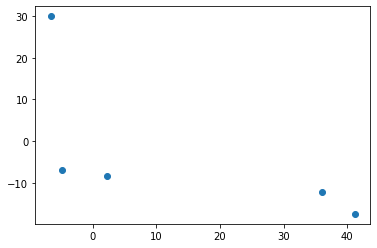

In [9]:
_ = plt.scatter(drones_locations[:,0], drones_locations[:,1])